<a href="https://colab.research.google.com/github/JozefSL/pyNotes/blob/main/XGB/Joaqu%C3%ADn_Amat_Rodrigo_rc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source: https://www.cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html

In [2]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [4]:
!pip install skforecast

     |████████████████████████████████| 81 kB 3.7 MB/s 
     |████████████████████████████████| 9.8 MB 35.0 MB/s 
     |████████████████████████████████| 15.7 MB 44.3 MB/s 
     |████████████████████████████████| 11.3 MB 42.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
google-colab 1

In [1]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

In [2]:
# Downloading data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-'
       'learning-python/master/data/bike_sharing_dataset_clean.csv')
data = pd.read_csv(url)
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date_time')
data = data.asfreq('H')
data = data.sort_index()
data

,holiday,workingday,weather,temp,atemp,hum,windspeed,users,month,hour,weekday
date_time,,,,,,,,,,,
2011-01-01 00:00:00,0.0,0.0,clear,9.84,14.395,81.0,0.0000,16.0,1,0,5
2011-01-01 01:00:00,0.0,0.0,clear,9.02,13.635,80.0,0.0000,40.0,1,1,5
2011-01-01 02:00:00,0.0,0.0,clear,9.02,13.635,80.0,0.0000,32.0,1,2,5
2011-01-01 03:00:00,0.0,0.0,clear,9.84,14.395,75.0,0.0000,13.0,1,3,5
2011-01-01 04:00:00,0.0,0.0,clear,9.84,14.395,75.0,0.0000,1.0,1,4,5
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,0.0,1.0,mist,10.66,12.880,60.0,11.0014,119.0,12,19,0
2012-12-31 20:00:00,0.0,1.0,mist,10.66,12.880,60.0,11.0014,89.0,12,20,0
2012-12-31 21:00:00,0.0,1.0,clear,10.66,12.880,60.0,11.0014,90.0,12,21,0


In [3]:
# Split train-val-test
# ==============================================================================
end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2011-01-01 00:00:00 --- 2012-03-31 23:00:00  (n=10944)
Dates validacion : 2012-04-01 00:00:00 --- 2012-08-31 23:00:00  (n=3672)
Dates test       : 2012-09-01 00:00:00 --- 2012-12-31 23:00:00  (n=2928)


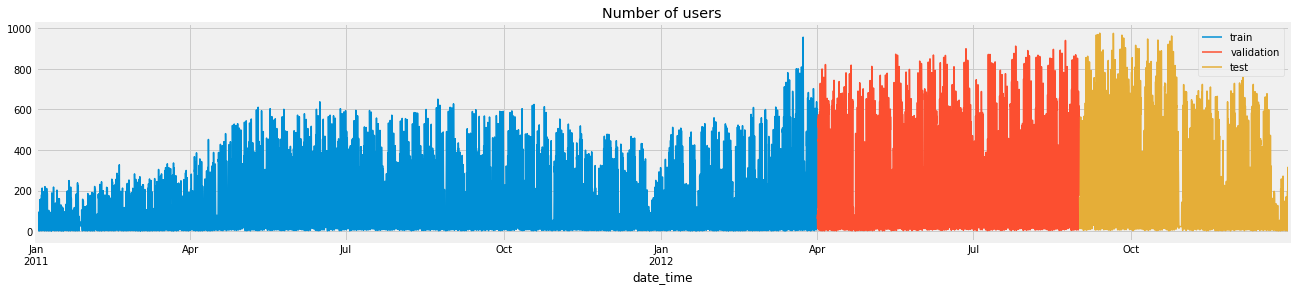

In [6]:
# Plot time series
# ==============================================================================
fig, ax = plt.subplots(figsize=(20, 4))
data_train['users'].plot(ax=ax, label='train')
data_val['users'].plot(ax=ax, label='validation')
data_test['users'].plot(ax=ax, label='test')
ax.set_title('Number of users')
ax.legend();

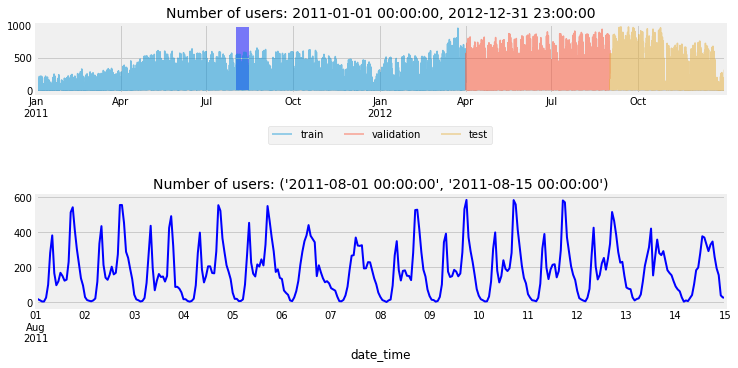

In [7]:
#  Plot time series with zoom
# ==============================================================================
zoom = ('2011-08-01 00:00:00','2011-08-15 00:00:00')

fig = plt.figure(figsize=(11, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

data_train['users'].plot(ax=main_ax, label='train', alpha=0.5)
data_val['users'].plot(ax=main_ax, label='validation', alpha=0.5)
data_test['users'].plot(ax=main_ax, label='test', alpha=0.5)
min_y = min(data['users'])
max_y = max(data['users'])
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
main_ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.8))

data.loc[zoom[0]: zoom[1]]['users'].plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Number of users: {data.index.min()}, {data.index.max()}', fontsize=14)
zoom_ax.set_title(f'Number of users: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)

In [8]:
# Interactive plot of time series
# ==============================================================================
data.loc[:end_train, 'partition'] = 'train'
data.loc[end_train:end_validation, 'partition'] = 'validation'
data.loc[end_validation:, 'partition'] = 'test'

fig = px.line(
    data_frame = data.reset_index(),
    x      = 'date_time',
    y      = 'users',
    color  = 'partition',
    title  = 'Number of users',
    width  = 900,
    height = 500
)

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

data=data.drop(columns='partition')

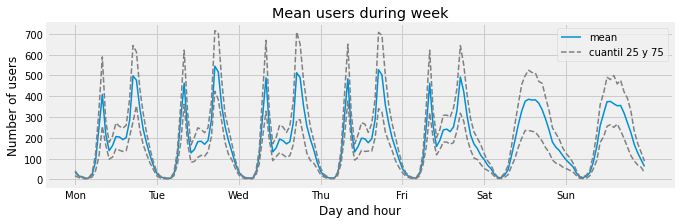

In [9]:
# Boxplot chart for daily seasonality
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 3))
mean_day_hour = data.groupby(["weekday", "hour"])["users"].mean()
q25_dia_hora = data.groupby(["weekday", "hour"])["users"].quantile(0.25)
q75_dia_hora = data.groupby(["weekday", "hour"])["users"].quantile(0.75)

mean_day_hour.plot(ax=ax, label='mean')
q25_dia_hora.plot(ax=ax, linestyle='dashed', color='gray', label='')
q75_dia_hora.plot(ax=ax, linestyle='dashed', color='gray', label='cuantil 25 y 75')


ax.set(
    title="Mean users during week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel="Day and hour",
    ylabel="Number of users"
)

ax.legend();

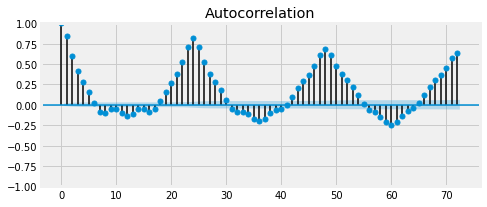

In [10]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(data['users'], ax=ax, lags=72)
plt.show()

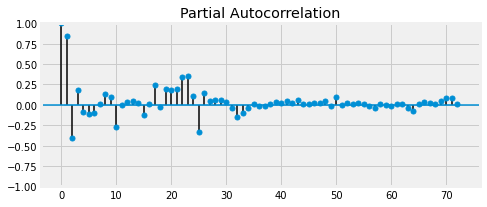

In [11]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(data['users'], ax=ax, lags=72, method='ywm')
plt.show()

In [12]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 24
             )

forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 123, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1} 
Creation date: 2022-01-21 01:15:26 
Last fit date: None 
Skforecast version: 0.4.2 

In [13]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]


results_grid = grid_search_forecaster(
        forecaster         = forecaster,
        y                  = data.loc[:end_validation, 'users'], # Train and validation data
        param_grid         = param_grid,
        lags_grid          = lags_grid,
        steps              = 36,
        refit              = False,
        metric             = 'mean_squared_error',
        initial_train_size = int(len(data_train)), # Model is trained with trainign data
        return_best        = True,
        verbose            = False
)

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

[01:16:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   8%|███                                  | 1/12 [00:01<00:18,  1.68s/it]

[01:16:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  17%|██████▏                              | 2/12 [00:07<00:40,  4.06s/it]

[01:16:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  25%|█████████▎                           | 3/12 [00:09<00:29,  3.33s/it]

[01:16:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  33%|████████████▎                        | 4/12 [00:20<00:48,  6.11s/it]

[01:16:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  42%|███████████████▍                     | 5/12 [00:26<00:43,  6.22s/it]

[01:16:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  50%|██████████████████▌                  | 6/12 [00:58<01:29, 14.85s/it]

[01:17:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|█████████████████████▌               | 7/12 [00:59<00:52, 10.50s/it]

[01:17:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  67%|████████████████████████▋            | 8/12 [01:05<00:35,  8.96s/it]

[01:17:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  75%|███████████████████████████▊         | 9/12 [01:07<00:20,  6.89s/it]

[01:17:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  83%|██████████████████████████████      | 10/12 [01:17<00:15,  7.67s/it]

[01:17:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  92%|█████████████████████████████████   | 11/12 [01:23<00:07,  7.09s/it]

[01:17:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

[01:18:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   8%|███                                  | 1/12 [00:02<00:26,  2.42s/it]

[01:18:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  17%|██████▏                              | 2/12 [00:12<01:06,  6.67s/it]

[01:18:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  25%|█████████▎                           | 3/12 [00:16<00:49,  5.46s/it]

[01:18:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  33%|████████████▎                        | 4/12 [00:33<01:21, 10.25s/it]

[01:18:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  42%|███████████████▍                     | 5/12 [00:44<01:13, 10.49s/it]

[01:18:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  50%|██████████████████▌                  | 6/12 [01:38<02:31, 25.32s/it]

[01:19:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|█████████████████████▌               | 7/12 [01:41<01:29, 17.81s/it]

[01:19:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  67%|████████████████████████▋            | 8/12 [01:50<01:00, 15.18s/it]

[01:19:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  75%|███████████████████████████▊         | 9/12 [01:54<00:34, 11.60s/it]

[01:19:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  83%|██████████████████████████████      | 10/12 [02:10<00:26, 13.06s/it]

[01:20:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  92%|█████████████████████████████████   | 11/12 [02:20<00:12, 12.06s/it]

[01:20:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

[01:21:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   8%|███                                  | 1/12 [00:03<00:35,  3.19s/it]

[01:21:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  17%|██████▏                              | 2/12 [00:16<01:32,  9.26s/it]

[01:21:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  25%|█████████▎                           | 3/12 [00:22<01:07,  7.55s/it]

[01:21:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  33%|████████████▎                        | 4/12 [00:46<01:53, 14.25s/it]

[01:21:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  42%|███████████████▍                     | 5/12 [01:01<01:42, 14.59s/it]

[01:22:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  50%|██████████████████▌                  | 6/12 [02:18<03:34, 35.75s/it]

[01:23:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|█████████████████████▌               | 7/12 [02:21<02:05, 25.11s/it]

[01:23:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  67%|████████████████████████▋            | 8/12 [02:35<01:25, 21.37s/it]

[01:23:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  75%|███████████████████████████▊         | 9/12 [02:40<00:48, 16.31s/it]

[01:23:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  83%|██████████████████████████████      | 10/12 [03:03<00:36, 18.26s/it]

[01:24:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  92%|█████████████████████████████████   | 11/12 [03:16<00:16, 16.77s/it]

[01:24:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

[01:25:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   8%|███                                  | 1/12 [00:01<00:11,  1.01s/it]

[01:25:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  17%|██████▏                              | 2/12 [00:04<00:23,  2.33s/it]

[01:25:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  25%|█████████▎                           | 3/12 [00:05<00:17,  1.92s/it]

[01:25:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  33%|████████████▎                        | 4/12 [00:11<00:26,  3.35s/it]

[01:25:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  42%|███████████████▍                     | 5/12 [00:14<00:22,  3.27s/it]

[01:25:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  50%|██████████████████▌                  | 6/12 [00:29<00:43,  7.29s/it]

[01:25:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|█████████████████████▌               | 7/12 [00:30<00:26,  5.23s/it]

[01:25:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  67%|████████████████████████▋            | 8/12 [00:33<00:18,  4.56s/it]

[01:25:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:34<00:10,  3.57s/it]

[01:25:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  83%|██████████████████████████████      | 10/12 [00:40<00:08,  4.06s/it]

[01:26:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:43<00:03,  3.71s/it]

[01:26:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop lags_grid: 100%|██████████████████████████████████████| 4/4 [10:01<00:00, 150.40s/it]


[01:26:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 13132.573921921889



In [14]:
# Results of grid search
# ==============================================================================
results_grid.head(10)

,lags,params,metric,learning_rate,max_depth,n_estimators
33,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",13132.573922,0.10,5.0,500.0
32,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",14407.853500,0.10,5.0,100.0
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",14677.093149,0.10,5.0,500.0
34,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",14959.220417,0.10,10.0,100.0
19,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",15135.992064,0.10,3.0,500.0
31,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",15198.601779,0.10,3.0,500.0
35,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",15540.350962,0.10,10.0,500.0
23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",15922.192907,0.10,10.0,500.0
27,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",16312.056702,0.01,5.0,500.0
22,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",16431.762045,0.10,10.0,100.0


In [15]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = data['users'],
    initial_train_size = len(data.loc[:end_validation]),
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
)

print(f"Backtest error: {metric}")

[01:31:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:31:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Backtest error: [12170.9502383]


In [16]:
# Predictions
# ==============================================================================
predictions

,pred
2012-09-01 00:00:00,126.663780
2012-09-01 01:00:00,55.589142
2012-09-01 02:00:00,31.353731
2012-09-01 03:00:00,9.031092
2012-09-01 04:00:00,5.923357
...,...
2012-12-31 19:00:00,149.999588
2012-12-31 20:00:00,98.918289
2012-12-31 21:00:00,77.868027
2012-12-31 22:00:00,54.168060


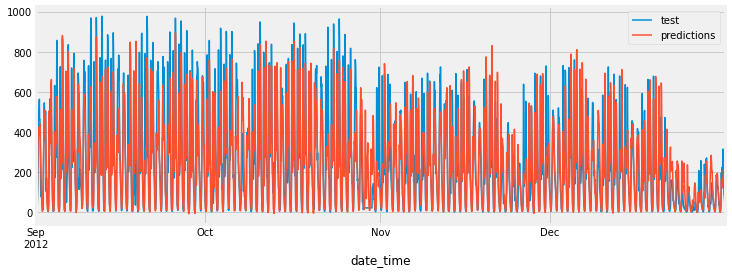

In [17]:
# Plot of predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data_test['users'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

In [18]:
# Interactive plot of predictions
# ==============================================================================
data_plot = pd.DataFrame({
                'test': data_test['users'],
                'prediction': predictions['pred'],

                 })
data_plot.index.name = 'date_time'

fig = px.line(
    data_frame = data_plot.reset_index(),
    x      = 'date_time',
    y      = data_plot.columns,
    title  = 'Number of users',
    width  = 900,
    height = 500
)

fig.update_xaxes(rangeslider_visible=True)
fig.show()

ValueError: ignored

In [19]:
# Store categorical variables as category type
# ==============================================================================
data['weather'] = data['weather'].astype('category')
data['month']   = data['month'].astype('category')
data['weekday'] = data['weekday'].astype('category')

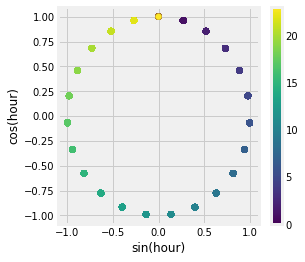

In [20]:
# Transformation sine-cosine of variable hour
# ==============================================================================
data['hour_sin'] = np.sin(data['hour'] / 23 * 2 * np.pi)
data['hour_cos'] = np.cos(data['hour'] / 23 * 2 * np.pi)

# Plot of the transformation
# ==============================================================================
fig, ax = plt.subplots(figsize=(4, 4))
sp = ax.scatter(data["hour_sin"], data["hour_cos"], c=data["hour"])
ax.set(
    xlabel="sin(hour)",
    ylabel="cos(hour)",
)
_ = fig.colorbar(sp)

data = data.drop(columns='hour')

In [21]:
# One hot encoding
# ==============================================================================
data = pd.get_dummies(data, columns=['weather', 'month', 'weekday'])
data.head(3)

,holiday,workingday,temp,atemp,hum,windspeed,users,hour_sin,hour_cos,weather_clear,weather_mist,weather_rain,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0.0,0.0,9.84,14.395,81.0,0.0,16.0,0.000000,1.000000,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2011-01-01 01:00:00,0.0,0.0,9.02,13.635,80.0,0.0,40.0,0.269797,0.962917,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2011-01-01 02:00:00,0.0,0.0,9.02,13.635,80.0,0.0,32.0,0.519584,0.854419,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [22]:
# Select exogenous variables, including those generated by one hot encoding.
exog_variables = [column for column in data.columns
                      if column.startswith(('weather', 'month', 'hour', 'weekday'))]
exog_variables.extend(['holiday', 'temp', 'atemp', 'hum', 'windspeed'])
print(exog_variables)

['hour_sin', 'hour_cos', 'weather_clear', 'weather_mist', 'weather_rain', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'holiday', 'temp', 'atemp', 'hum', 'windspeed']


In [23]:
# Since data has been transformed, the train, val and test split is repeated.
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

In [24]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 24
             )

In [25]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, 'users'],
                        exog               = data.loc[:end_validation, exog_variables],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 36,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)),
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 24


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

[01:33:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   8%|███                                  | 1/12 [00:04<00:47,  4.29s/it]

[01:33:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  17%|██████▏                              | 2/12 [00:21<01:58, 11.87s/it]

[01:33:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  25%|█████████▎                           | 3/12 [00:28<01:26,  9.58s/it]

[01:33:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  33%|████████████▎                        | 4/12 [00:58<02:21, 17.69s/it]

[01:34:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  42%|███████████████▍                     | 5/12 [01:16<02:04, 17.77s/it]

[01:34:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  50%|██████████████████▌                  | 6/12 [02:43<04:07, 41.29s/it]

[01:35:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|█████████████████████▌               | 7/12 [02:47<02:25, 29.17s/it]

[01:35:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  67%|████████████████████████▋            | 8/12 [03:04<01:41, 25.32s/it]

[01:36:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  75%|███████████████████████████▊         | 9/12 [03:11<00:58, 19.48s/it]

[01:36:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  83%|██████████████████████████████      | 10/12 [03:39<00:44, 22.17s/it]

[01:36:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  92%|█████████████████████████████████   | 11/12 [03:55<00:20, 20.39s/it]

[01:37:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

[01:38:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   8%|███                                  | 1/12 [00:02<00:22,  2.02s/it]

[01:38:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  17%|██████▏                              | 2/12 [00:09<00:49,  4.94s/it]

[01:38:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  25%|█████████▎                           | 3/12 [00:11<00:35,  3.99s/it]

[01:38:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  33%|████████████▎                        | 4/12 [00:23<00:54,  6.84s/it]

[01:38:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  42%|███████████████▍                     | 5/12 [00:29<00:47,  6.73s/it]

[01:38:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  50%|██████████████████▌                  | 6/12 [00:59<01:28, 14.70s/it]

[01:39:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  58%|█████████████████████▌               | 7/12 [01:01<00:52, 10.56s/it]

[01:39:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  67%|████████████████████████▋            | 8/12 [01:08<00:37,  9.38s/it]

[01:39:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  75%|███████████████████████████▊         | 9/12 [01:11<00:22,  7.34s/it]

[01:39:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  83%|██████████████████████████████      | 10/12 [01:22<00:16,  8.34s/it]

[01:39:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  92%|█████████████████████████████████   | 11/12 [01:28<00:07,  7.64s/it]

[01:39:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop lags_grid: 100%|██████████████████████████████████████| 2/2 [06:58<00:00, 209.30s/it]


[01:40:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 8912.66273687791



In [26]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = data['users'],
    exog               = data[exog_variables],
    initial_train_size = len(data.loc[:end_validation]),
    steps              = 36,
    refit              = False,
    metric             = 'mean_squared_error',
    verbose            = False
)

print(f"Backtest error: {metric}")

[01:40:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:40:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Backtest error: [6388.02243398]


In [27]:
# Extract feature importance
# ==============================================================================
importance = forecaster.get_feature_importance()
importance

,feature,importance
0,lag_1,0.248002
1,lag_2,0.005347
2,lag_3,0.003233
3,lag_4,0.005951
4,lag_5,0.002000
...,...,...
96,holiday,0.001043
97,temp,0.001690
98,atemp,0.002490
99,hum,0.001414


In [28]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags = 24
             )

forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2022-01-21 01:41:16 
Last fit date: None 
Skforecast version: 0.4.2 

In [29]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, 'users'],
                        exog               = data.loc[:end_validation, exog_variables],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 36,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)),
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 24


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [01:24<00:00, 42.45s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 8814.536841168821



In [30]:
# Results grid search
# ==============================================================================
results_grid.head(10)

,lags,params,metric,learning_rate,max_depth,n_estimators
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",8814.536841,0.10,10.0,500.0
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",8838.983329,0.10,3.0,500.0
23,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",9033.934124,0.10,10.0,500.0
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",9034.016763,0.10,5.0,500.0
21,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",9460.577093,0.10,5.0,500.0
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",9699.111031,0.10,10.0,100.0
19,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",10234.834660,0.10,3.0,500.0
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",10844.341010,0.10,5.0,100.0
22,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",11092.127609,0.10,10.0,100.0
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",11938.993487,0.01,10.0,500.0


In [31]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = data['users'],
    exog               = data[exog_variables],
    initial_train_size = len(data.loc[:end_validation]),
    steps              = 36,
    refit              = False,
    metric             = 'mean_squared_error',
    verbose            = False
)

print(f"Backtest error: {metric}")

Backtest error: [5932.9168588]


In [32]:
# Feature importance
# ==============================================================================
impotance = forecaster.get_feature_importance()
impotance

,feature,importance
0,lag_1,785
1,lag_2,300
2,lag_3,208
3,lag_4,300
4,lag_5,186
...,...,...
96,holiday,22
97,temp,195
98,atemp,201
99,hum,284


In [33]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = CatBoostRegressor(random_state=123, silent=True),
                lags = 24
             )

forecaster

ForecasterAutoreg 
Regressor: <catboost.core.CatBoostRegressor object at 0x7f955a8a6290> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'loss_function': 'RMSE', 'silent': True, 'random_state': 123} 
Creation date: 2022-01-21 01:43:02 
Last fit date: None 
Skforecast version: 0.4.2 

In [34]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, 'users'],
                        exog               = data.loc[:end_validation, exog_variables],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 36,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)),
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 24


loop lags_grid: 100%|██████████████████████████████████████| 2/2 [07:11<00:00, 215.67s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 6779.454203090569



In [35]:
# Results grid search
# ==============================================================================
results_grid.head(10)

,lags,params,metric,learning_rate,max_depth,n_estimators
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",6779.454203,0.1,5.0,500.0
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",8013.664614,0.1,3.0,500.0
21,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",8107.921257,0.1,5.0,500.0
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",9269.532296,0.1,10.0,500.0
23,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",9613.039031,0.1,10.0,500.0
19,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",9696.337248,0.1,3.0,500.0
22,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",10396.453214,0.1,10.0,100.0
20,"[1, 2, 3, 23, 24, 25, 71, 72, 73]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",10670.330703,0.1,5.0,100.0
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",11129.672504,0.1,5.0,100.0
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",11467.609975,0.1,10.0,100.0


In [36]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = data['users'],
    exog               = data[exog_variables],
    initial_train_size = len(data.loc[:end_validation]),
    steps              = 36,
    refit              = False,
    metric             = 'mean_squared_error',
    verbose            = False
)

print(f"Backtest error: {metric}")

Backtest error: [5801.14436506]
